In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
from scipy.stats import norm
from dieboldmariano import dm_test

import torch
import pickle
import random

In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
Year = 2020

In [4]:
bidirectional_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Norway/test_predictions_with_hgru.pickle'
hgru_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/hgru_model_norway/test_predictions.pickle'
baseline_results_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/basic_model_norway/data/predictions_dict.pickle'

actual_path = '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_dataset_dict.pickle'

In [5]:
with open(bidirectional_results_path, 'rb') as f:
    bidirectional_preds = pickle.load(f)

with open(hgru_results_path, 'rb') as f:
    hgru_preds = pickle.load(f)

with open(baseline_results_path, 'rb') as f:
    baseline_preds = pickle.load(f)

with open(actual_path, 'rb') as f:
    raw_dataset_dict = pickle.load(f)

In [6]:
bidirectional_preds['All-items'].shape

torch.Size([1, 28])

In [7]:
hgru_preds['All-items'].shape

torch.Size([1, 28])

In [8]:
baseline_preds['All-items'].shape

torch.Size([1, 28])

In [9]:
raw_dataset_dict['All-items']

,Category_id,Category,Year,Date,Price,Inflation t-12,Inflation t-11,Inflation t-10,Inflation t-9,Inflation t-8,...,Inflation t-4,Inflation t-3,Inflation t-2,Inflation t-1,Inflation t,Inflation t+1,Indent,Weight,Parent,Parent_ID
0,0,All-items,2009,2009-01-15,88.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.786079,0,1000.0,NaN,NaN
1,0,All-items,2009,2009-02-15,89.4,0.786079,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0,1000.0,NaN,NaN
2,0,All-items,2009,2009-03-15,89.4,0.000000,0.786079,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.335009,0,1000.0,NaN,NaN
3,0,All-items,2009,2009-04-15,89.7,0.335009,0.000000,0.786079,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.222717,0,1000.0,NaN,NaN
4,0,All-items,2009,2009-05-15,89.9,0.222717,0.335009,0.000000,0.786079,NaN,...,NaN,NaN,NaN,NaN,NaN,0.554633,0,1000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0,All-items,2023,2023-01-15,126.1,0.158730,0.079460,-0.158856,0.317965,1.362747,...,0.247219,1.161839,0.586021,1.097521,-0.929453,0.395727,0,1000.0,NaN,NaN
169,0,All-items,2023,2023-02-15,126.6,0.395727,0.158730,0.079460,-0.158856,0.317965,...,0.901276,0.247219,1.161839,0.586021,1.097521,0.786786,0,1000.0,NaN,NaN
170,0,All-items,2023,2023-03-15,127.6,0.786786,0.395727,0.158730,0.079460,-0.158856,...,1.296615,0.901276,0.247219,1.161839,0.586021,1.091203,0,1000.0,NaN,NaN
171,0,All-items,2023,2023-04-15,129.0,1.091203,0.786786,0.395727,0.158730,0.079460,...,-0.241838,1.296615,0.901276,0.247219,1.161839,0.464038,0,1000.0,NaN,NaN


In [10]:
def create_test_dataframe(raw_dataset_dict: dict):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+1']]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
        target_df = df[df['Year'] > Year]
        test_dict[key] = target_df
    return test_dict

test_dict = create_test_dataframe(raw_dataset_dict)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_64034/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_64034/483307922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_64034/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [11]:
def get_df_with_predictions(bi_direc_preds: dict, hrnn_preds: dict, baseline_preds: dict, dict_of_categories_df:dict) -> dict:
    all_data_dict = {}
    for key in list(bi_direc_preds.keys()):
        bi_directional_predictions = bi_direc_preds[key]
        hrnn_predictions = hrnn_preds[key]
        baseline_predictions = baseline_preds[key]
        
        bi_directional_pred_df =  pd.DataFrame(bi_directional_predictions.flatten().detach().numpy())
        bi_directional_pred_df.rename(columns = {0: 'Bi-Directional Prediction'}, inplace=True)
        
        hrnn_pred_df =  pd.DataFrame(hrnn_predictions.flatten().detach().numpy())
        hrnn_pred_df.rename(columns = {0: 'HRNN Prediction'}, inplace=True)

        baseline_pred_df =  pd.DataFrame(baseline_predictions.flatten().detach().numpy())
        baseline_pred_df.rename(columns = {0: 'Baseline Prediction'}, inplace=True)

        dict_of_categories_df[key] = dict_of_categories_df[key].reset_index(drop=True)
        df1 = pd.concat([dict_of_categories_df[key], bi_directional_pred_df], axis=1)
        df2 = pd.concat([df1, hrnn_pred_df], axis=1)
        df3 = pd.concat([df2, baseline_pred_df], axis=1)

        all_data_dict[key] = df3

    return all_data_dict

all_data_test_dict=get_df_with_predictions(bidirectional_preds, hgru_preds, baseline_preds , test_dict)

In [12]:
def diebold_mariano_test_better_categories(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [13]:
res = diebold_mariano_test_better_categories(all_data_test_dict)

Number of Better Categories: 50
Total Categories: 52
Better Category %: 96.1538
Average P-value Better Categories: 0.06147674902260178
Average P-value All Categories: 0.083979135952693


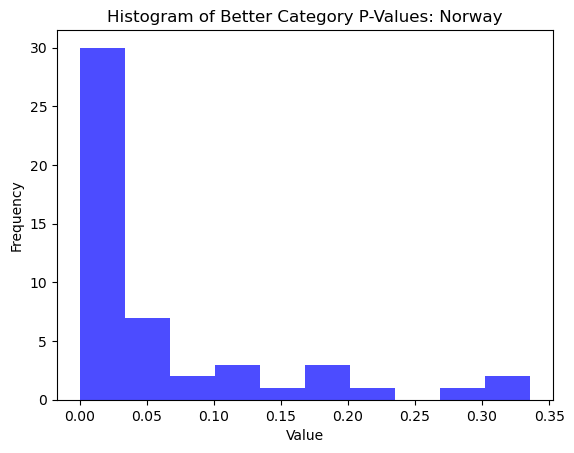

In [14]:

# Creating the histogram
plt.hist(res[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


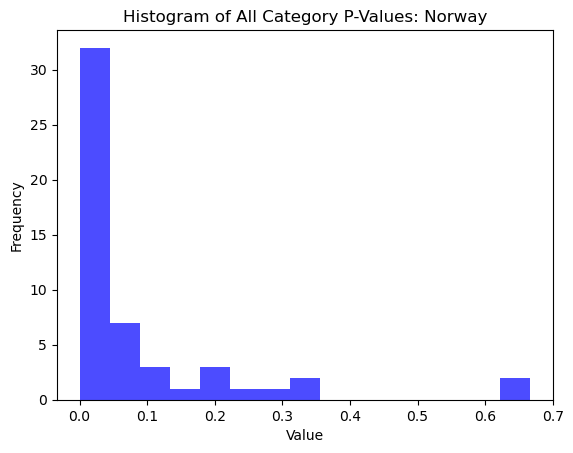

In [15]:

# Creating the histogram
plt.hist(res[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [16]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.1):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [17]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 39
Total Categories: 52
Better Category %: 75.0
Average P-value Better Categories: 0.021372800123679828
Average P-value All Categories: 0.083979135952693


In [18]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.05):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Average P-value Better Categories: {np.mean(better_cats_pval)}')
    print(f'Average P-value All Categories: {np.mean(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [19]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 33
Total Categories: 52
Better Category %: 63.4615
Average P-value Better Categories: 0.013750729467024499
Average P-value All Categories: 0.083979135952693


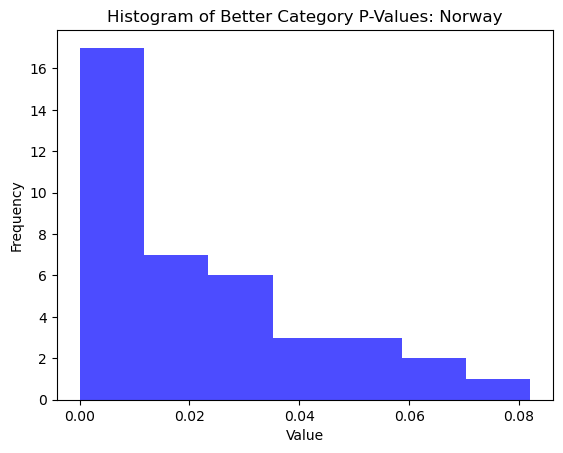

In [18]:
# Creating the histogram
plt.hist(res2[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


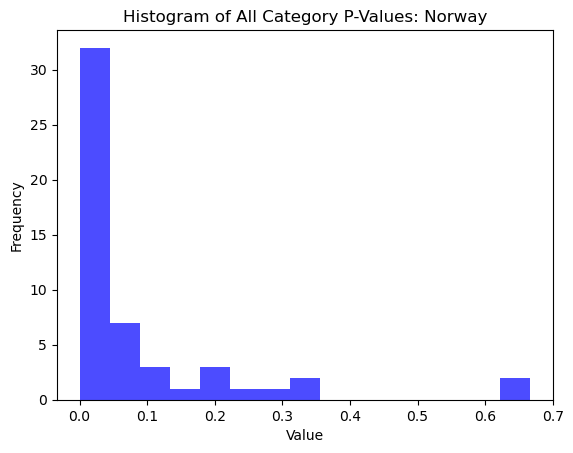

In [19]:

# Creating the histogram
plt.hist(res2[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


------

In [20]:
def diebold_mariano_test(forecast_model1, forecast_model2, actual_values):
    # Calculate squared forecast errors for both models
    squared_errors_model1 = (forecast_model1 - actual_values)**2
    squared_errors_model2 = (forecast_model2 - actual_values)**2
    
    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_model1 = np.mean(squared_errors_model1)
    msfe_model2 = np.mean(squared_errors_model2)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_model1 - msfe_model2
    
    # Calculate the variance of the difference
    var_diff = np.var(squared_errors_model1 - squared_errors_model2) / len(actual_values)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
    
    return dm_statistic, p_value

In [21]:
def diebold_mariano_test_all_categories(all_data_test_dict):
    list_of_squared_errors_bi_directional = []
    list_of_squared_errors_hrnn = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        # Calculate squared forecast errors for both models
        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        list_of_squared_errors_bi_directional.append(squared_errors_bi_directional)
        list_of_squared_errors_hrnn.append(squared_errors_hrnn)

    list_of_squared_errors_bi_directional = pd.concat(list_of_squared_errors_bi_directional)
    list_of_squared_errors_hrnn = pd.concat(list_of_squared_errors_hrnn)

    #print(f'num categories: {len(list(all_data_test_dict.keys()))}')
    #print(f'list of sqrd errors bi directional: {len(list_of_squared_errors_bi_directional)}')
    #print(f'list of sqrd errors: {len(list_of_squared_errors_hrnn)}')


    # Calculate Mean Squared Forecast Errors (MSFE) for both models
    msfe_bi_directional = np.mean(list_of_squared_errors_bi_directional)
    msfe_hrnn = np.mean(list_of_squared_errors_hrnn)
    
    # Calculate the difference in MSFE
    diff_msfe = msfe_bi_directional - msfe_hrnn

    # Calculate the variance of the difference
    var_diff = np.var(list_of_squared_errors_bi_directional - list_of_squared_errors_hrnn) / len(list_of_squared_errors_bi_directional)
    
    # Calculate the Diebold-Mariano test statistic
    dm_statistic = diff_msfe / np.sqrt(var_diff)
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))  # Two-tailed test
        
    return dm_statistic, p_value

In [22]:
dm_statistic, p_value = diebold_mariano_test_all_categories(all_data_test_dict)

alpha = 0.05  # Significance level (adjust as needed)

print("Diebold-Mariano Test Statistic:", dm_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("Conclusion: There is a statistically significant difference in predictive accuracy between the two models.")
else:
    print("Conclusion: There is no statistically significant difference in predictive accuracy between the two models.")


Diebold-Mariano Test Statistic: -5.252096874316142
p-value: 1.5037732969958029e-07
Conclusion: There is a statistically significant difference in predictive accuracy between the two models.


In [23]:
from dm_test import dm_test
dm_dict = {}
dm_dict_pvalues = {}

for category in list(all_data_test_dict.keys()):
#for category in ['Other lessons, courses and education services']:
    if category == 'Other lessons, courses and education services':
        continue
    print(category)
    df = all_data_test_dict[category]
    actual_lst = df['Actual'].apply(lambda x: float(x)).tolist()
    bidirect_pred_lst = df['Bi-Directional Prediction'].apply(lambda x: float(x)).tolist()
    hrnn_pred_lst = df['HRNN Prediction'].apply(lambda x: float(x)).tolist()

    rt = dm_test(actual_lst ,bidirect_pred_lst, hrnn_pred_lst, h = 1, crit="MSE")
    p_value = rt[-1]

    dm_dict_pvalues[category] = p_value

    if p_value<= 0.01:
        dm_dict[category] = 1
    else:
        dm_dict[category] = 0


Accommodation services
Actual rentals for housing
Alcoholic beverages
Audio-visual, photographic and information processing equipment
Clothing
Electricity, gas and other fuels
Financial services n.e.c.
Food
Footwear
Furniture and furnishings, carpets and other floor coverings
Glassware, tableware and household utensils
Goods and services for routine household maintenance
Household appliances
Household textiles
Imputed rentals for housing
Insurance
Maintenance and repair of the dwelling
Medical products, appliances and equipment
Newspapers, books and stationery
Non-alcoholic beverages
Operation of personal transport equipment
Other major durables for recreation and culture
Other recreational items and equipment, gardens and pets
Other services n.e.c.
Out-patient services
Package holidays
Personal care
Personal effects n.e.c.
Postal services
Purchase of vehicles
Recreational and cultural services
Restaurant services
Social protection
Telephone equipment
Telephone services
Tobacco
Tools a

In [24]:
values = list(dm_dict.values())
print(f'p values < 0.01 count: {sum(values)}')
print(f'total count: {len(values)}')
print(f'percentage: %{round(100*sum(values)/len(values),3)}')

p values < 0.01 count: 12
total count: 52
percentage: %23.077


In [25]:
p_values = list(dm_dict_pvalues.values())

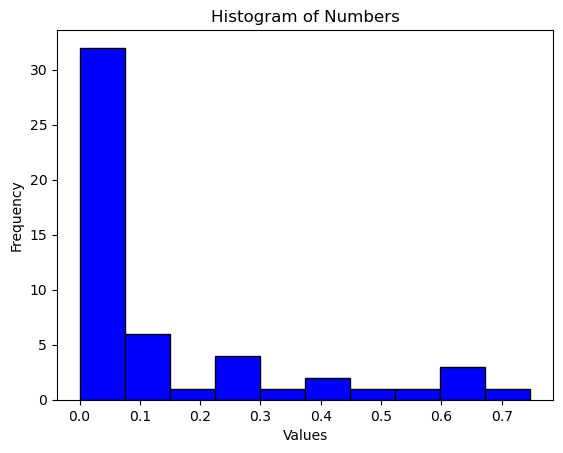

In [26]:
# Creating a histogram
plt.hist(p_values, bins=10, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Numbers')

# Display the histogram
plt.show()

In [27]:
np.mean(p_values)

0.1454138397210364

In [28]:
# Define percentiles you want to calculate
percentiles = [10, 25, 50, 75, 90]

# Calculate percentiles using numpy.percentile
percentile_values = np.percentile(p_values, percentiles)

# Display the results
for p, value in zip(percentiles, percentile_values):
    print(f'{p}th percentile: {value}')

10th percentile: 0.0021391752961935784
25th percentile: 0.012697593438558029
50th percentile: 0.05277415184248323
75th percentile: 0.18139274806333308
90th percentile: 0.44750799097848715
